In [1]:
# Import Libraries:
import pandas as pd
import numpy as np
import re 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
# Data Source: 'https://www.sports-reference.com/cfb/schools/michigan/index.html'

# Read in data (web page above saved as an html file)
wins = pd.read_html('Michigan_AP_Poll.html')
wins = pd.DataFrame(wins[0])

#drop big10 season records. Create weird, duplicate columns names
cols = [7, 8, 9]
wins.drop(wins.columns[cols],axis=1,inplace=True)

#Data cleaning, removing multi-layered axes
wins = wins.T
wins = wins.reset_index()
wins = pd.DataFrame(wins)
wins = wins.iloc[: , 1:]
wins = wins.T
wins.columns = wins.iloc[0]
wins = wins.iloc[1: , :]


#Regex pattern to get JUST the name of coach, and create a new column called "Coach"
pattern = '([A-Za-z]+\s{1}[A-Za-z]+[a-z]+)+.*'

# Apply regex patter to the df
wins['Coach'] = wins['Coach(es)'].apply(lambda x: (re.findall(pattern, str(x))))
wins['Coach'] = wins['Coach'].str[0]

#Drop columns we don't need
cols = [0, 7, 8, 9]
wins.drop(wins.columns[cols],axis=1,inplace=True)

# Remove summary rows that pop up every 20 season
wins = wins[wins['W'] != 'W']

# Create new column that sums the number of games played
wins['games_played'] = wins['W'].fillna('0').astype(int) + wins['L'].fillna('0').astype(int) + wins['T'].fillna('0').astype(int)

# Create new column: wins_normalized

# wins normalized is the number of wins the team would have had 13 game schedule (full 2021 schedule + a bowl game.)
# This is essential to compare against older teams that played fewer games
# if team didn't qualify for a bowl game, then it counts it as a loss
# Ties (which don't happen anymore) also count as losses now
wins['wins_normalized'] = (wins['W'].fillna('0').astype(int) / wins['games_played']) * 13

# Create a similar df as "wins" but it only includes seasons after 1950 (called wins_1950)

# This will upset some Michigan alumni, but if the team played with leather helmets 
# and used a literal pigskin for the ball then it's time to stop clinging to the past
wins_1950 = wins[wins['Year'] >= '1950']

# Data preview
wins.head(10)

level_1,Year,Conf,W,L,T,AP Pre,AP High,AP Post,Coach(es),Bowl,Notes,Coach,games_played,wins_normalized
0,2021,Big Ten,8,1,NaN,NaN,6,NaN,Jim Harbaugh (8-1),NaN,NaN,Jim Harbaugh,9,11.555556
1,2020,Big Ten,2,4,0,16,13,NaN,Jim Harbaugh (2-4),NaN,NaN,Jim Harbaugh,6,4.333333
2,2019,Big Ten,9,4,0,7,7,18,Jim Harbaugh (9-4),Citrus Bowl-L,NaN,Jim Harbaugh,13,9.000000
3,2018,Big Ten,10,3,0,14,4,14,Jim Harbaugh (10-3),Peach Bowl-L,NaN,Jim Harbaugh,13,10.000000
4,2017,Big Ten,8,5,0,11,7,NaN,Jim Harbaugh (8-5),Outback Bowl-L,NaN,Jim Harbaugh,13,8.000000
5,2016,Big Ten,10,3,0,7,2,10,Jim Harbaugh (10-3),Orange Bowl-L,NaN,Jim Harbaugh,13,10.000000
6,2015,Big Ten,10,3,0,NaN,12,12,Jim Harbaugh (10-3),Citrus Bowl-W,NaN,Jim Harbaugh,13,10.000000
7,2014,Big Ten,5,7,0,NaN,NaN,NaN,Brady Hoke (5-7),NaN,NaN,Brady Hoke,12,5.416667
8,2013,Big Ten,7,6,0,17,11,NaN,Brady Hoke (7-6),Buffalo Wild Wings Bowl-L,NaN,Brady Hoke,13,7.000000
9,2012,Big Ten,8,5,0,8,8,24,Brady Hoke (8-5),Outback Bowl-L,NaN,Brady Hoke,13,8.000000


In [3]:
wins = wins[wins['Year'].astype(int) >= 1950]


In [4]:
wins = wins[['Year', 'W', 'AP Post']]
wins = wins.dropna()

In [5]:
wins.head()

level_1,Year,W,AP Post
2,2019,9,18
3,2018,10,14
5,2016,10,10
6,2015,10,12
9,2012,8,24


In [6]:
## Feature Scaling
sc_dfa = StandardScaler()
dfa_std = sc_dfa.fit_transform(wins.astype(float))

In [7]:
## Clustering with KMeans
kmeans = KMeans(n_clusters=2, random_state=42).fit(dfa_std)
labels = kmeans.labels_

In [8]:
new_dfa = pd.DataFrame(data = dfa_std, columns = ['Year','W','AP High'])
new_dfa['label_kmeans'] = labels

In [9]:
new_dfa.nunique()

Year            49
W                7
AP High         20
label_kmeans     2
dtype: int64

In [10]:
wins.reset_index().head()

level_1,index,Year,W,AP Post
0,2,2019,9,18
1,3,2018,10,14
2,5,2016,10,10
3,6,2015,10,12
4,9,2012,8,24


In [11]:
#new_dfa = pd.merge(left = new_dfa, right = wins, how = 'left')

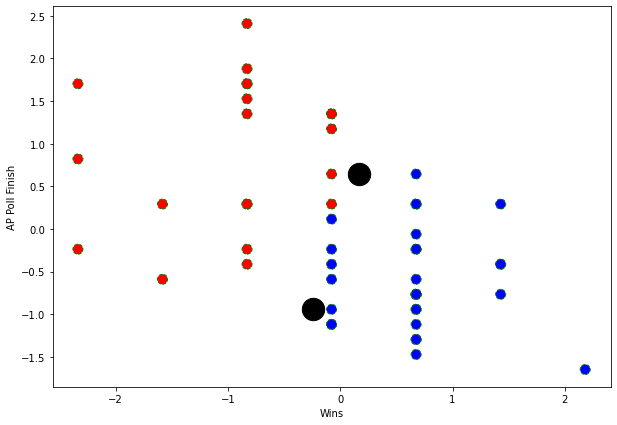

In [12]:
fig, ax = plt.subplots(figsize=(10,7))
plt.scatter(new_dfa["W"][new_dfa["label_kmeans"] == 0], new_dfa["AP High"][new_dfa["label_kmeans"] == 0], 
            color = "blue", s=100, edgecolor='green',linestyle='--')

plt.scatter(new_dfa["W"][new_dfa["label_kmeans"] == 1], new_dfa["AP High"][new_dfa["label_kmeans"] == 1], 
            color = "red", s=100, edgecolor='green',linestyle='--')

plt.scatter(new_dfa["W"][new_dfa["label_kmeans"] == 2], new_dfa["AP High"][new_dfa["label_kmeans"] == 2], 
            color = "green", s=100, edgecolor='green',linestyle='--')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=500);

ax.set_xlabel('Wins')
ax.set_ylabel('AP Poll Finish')




plt.show()

In [13]:
type(new_dfa['Year'])

pandas.core.series.Series